In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# from utils.disease_name_mapping import dict_disease_name_mapping
# import utils.disease_name_mapping as dnm
# print(dir(dnm))
### READ DATA ###

df_raw = pd.read_csv('data/TCDCIntlEpidAll.csv')


### DATA CLEANING ###

df_raw["date"] = pd.to_datetime(df_raw['effective']).dt.date
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')

df_raw[['headline_country', 'headline_disease']] = df_raw['headline'].str.split(r'[-－─]', n=1, expand=True) 
    # either half-width - or full-width － or Box-drawing dash ─
df_raw['headline_country'] = df_raw['headline_country'].str.strip()
df_raw['headline_disease'] = df_raw['headline_disease'].str.strip()

df_raw = df_raw.drop(
    ["sent", "effective", "source", "expires", "senderName", "instruction", "web", "alert_title", "severity_level", "circle", "headline"], axis=1)




print(df_raw.head(2))

#disease name frequency
table_disease_freq = df_raw['headline_disease'].value_counts()

print(table_disease_freq.head(50))


table_alert_disease_freq = df_raw['alert_disease'].value_counts()
print(table_alert_disease_freq.head(50))


                                         description   alert_disease  \
0  全球小兒麻痺根除倡議組織(GPEI)公布於5/8-14期間，cVDPV2型新增4國共9例，分...  小兒麻痺症/急性無力肢體麻痺   
1  美國於5/19累計15州報告26例病例，其中9例住院，經調查疑感染源為生產自佛羅里達州某廠商...         沙門氏菌感染症   

                                areaDesc  \
0  阿爾及利亞,布吉納法索,查德,象牙海岸,衣索比亞,巴基斯坦,索馬利亞,蘇丹   
1                                     美國   

                                         areaDesc_EN                  ISO3166  \
0  Algeria,Burkina Faso,Chad,Cote d'Ivoire,Ethiop...  DZ,BF,TD,CI,ET,PK,SO,SD   
1                                                USA                       US   

  areaDetail ISO3166_2       date headline_country headline_disease  
0        NaN       NaN 2025-05-23               全球            小兒麻痺症  
1        NaN       NaN 2025-05-23               美國     細菌性腸胃炎(沙門氏菌)  
headline_disease
登革熱               2261
禽類禽流感             1507
麻疹                1433
霍亂                 901
H1N1新型流感           887
腸病毒                846
新型冠狀病毒肺炎           833
小兒麻痺症             

In [ ]:
## Disease Name Mapping: for main name, sub name
# def clean_heading_disease_name(name):
#     name = re.sub(r'\(.*?\)', '', name)     # 移除括號內的內容
#     name = re.sub(r'^\d+', '', name)    # 去除數字開頭
#     return name.strip()

# df_raw['headline_disease'] = df_raw['headline_disease'].apply(clean_heading_disease_name)

dict_disease_name_mapping = { #multiple diseases are splitted by /
    '新型冠狀病毒肺炎': 'COVID-19',  #old name: new name
    '嚴重特殊傳染性肺炎': 'COVID-19',
    "新型冠狀肺炎": "COVID-19", # n=1
    #"新型冠狀病毒": "COVID-19", This is MERS
    "新冠併發重症(每週更新)": 'COVID-19',
    "新冠併發重症(本週更新)": "COVID-19", 
    '新冠併發重症': 'COVID-19',
    "猴痘": "M痘",
    "M痘(每月更新)": "M痘",
    "M痘(每週更新)": "M痘",
    "M痘(本週更新)": "M痘",
    "新型A型流感(每週更新)": "新型A型流感",
    '新型A型流感(本週更新)': "新型A型流感",
    '新型A型流感(H3N2v)': "新型A型流感",
    '新型A型流感(H9N2)' : "新型A型流感",
    "新型A型流感(H9N2/H10N3)": "新型A型流感",
    "新型A型流感(H5N1)": "新型A型流感",
    #"新型A型流感(哺乳動物感染禽流感)": "新型A型流感",
    "新型A型流感(H5)": "新型A型流感",
    'H7N9流感': '新型A型流感',
    "H5N1流感": "新型A型流感",
    "H3N8流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H3N2v流感": "新型A型流感",
    "H5流感":  "新型A型流感",
    "H1N2v流感": "新型A型流感",
    "H5N6流感": "新型A型流感",
    "H9N2流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H1N2v流感病例": "新型A型流感",
    "H1v流感":  "新型A型流感",
    'H3N2v流感': "新型A型流感",
    'H3N2v、H1N2v流感': "新型A型流感",
    "H1N1v流感": "新型A型流感",
    "H1N2流感": "新型A型流感",
    "H5N8流感": "新型A型流感",
    "H10N3流感" : "新型A型流感",
    "H1N1流感": "新型A型流感",
    "H1N1新型流感": "新型A型流感",
    "─H7N9流感": "新型A型流感",
    "Echovirus 30 (E30)": "腸病毒",
    '1腸道菌感染症': '腸道菌感染症',
    # "病毒性腸胃炎(諾羅病毒)": "",
    "病毒性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "沙門氏菌感染": "沙門氏菌感染症",
    "抗藥性沙門氏菌": "沙門氏菌感染症",
    "沙門氏菌": "沙門氏菌感染症",
    "沙門氏菌(Salmonella Agbeni)": "沙門氏菌感染症",
    "細菌性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "細菌性腸胃炎(曲狀桿菌/沙門氏菌)": "細菌性腸胃炎(曲狀桿菌)/沙門氏菌感染症",
    "曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "多重抗藥性曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "不明原因腹瀉": "腹瀉", # pending
    "不明原因疾病死亡": "不明原因致死疾病",
    "不明原因死亡": "不明原因致死疾病",
    "不明原因致死疾病(疑似炭疽病)": "不明原因致死疾病",
    "不明原因疾病(急性腹瀉與嘔吐)": "不明原因疾病",
    "不明原因肺炎": "不明原因疾病",
    "不明原因神經系統疾病":"不明原因疾病",
    '不明原因腦脊髓膜炎': "不明原因疾病",
    "不明原因出血": "不明原因疾病",
    "不明原因疾病(番茄流感)":  "不明原因疾病",
    "不明原因出血疾病": "不明原因疾病", 
    "不明原因急性肝炎": "不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明原因腦炎與細菌性腦膜炎": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因肝炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因肺炎": "不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明原因腦炎": "不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "人類免疫缺乏病毒感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV/AIDS": "人類免疫缺乏病毒(愛滋病毒)感染",
    "愛滋病": "人類免疫缺乏病毒(愛滋病毒)感染",
    "梅毒與先天性梅毒": "梅毒/先天性梅毒",
    "猩紅熱與侵襲性A群鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "猩紅熱與侵襲性A群鏈球菌感染症": "猩紅熱與A群鏈球菌感染",
    "猩紅熱及侵襲性A型鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "溶血性A群鏈球菌感染": "A群鏈球菌感染",
    "侵襲性A群鏈球菌": "A群鏈球菌感染",
    "克里米亞剛果出血熱": "克里米亞-剛果出血熱",
    "克里米-亞剛果出血熱": "克里米亞-剛果出血熱",
    "立百病毒": "立百病毒感染症",
    "立百病毒感染": "立百病毒感染症",
    "漢他病毒": "漢他病毒症後群",
    "漢他病毒感染症": "漢他病毒症後群",
    "漢他病毒出血熱": "漢他病毒症後群",
    "漢他病毒肺症候群": "漢他病毒症後群",
    "皮膚利什曼原蟲症" : "利什曼原蟲症", 
    "萊姆病、蜱媒腦炎": "萊姆病/蜱媒腦炎",
    "E型肝炎": "急性病毒性E型肝炎",
    "A型肝炎": "急性病毒性A型肝炎",
    "中東呼吸症候群冠狀病毒": "中東呼吸症候群冠狀病毒感染症",
    "發熱伴血小板減少綜合症(SFTS)":"發熱伴血小板減少綜合症",
    "傳染性紅斑": "傳染性紅斑症",
    "人類間質肺炎病毒(HMPV)": "人類間質肺炎病毒感染",
    "人類間質肺炎": "人類間質肺炎病毒感染",
    "人類間質肺炎病毒": "人類間質肺炎病毒感染",
    "伊波拉病毒": "伊波拉病毒感染", # Sudan病毒疾病是伊波拉病毒感染的一種
    "剛果出血熱死": "剛果出血熱",
    "急性無力脊髓炎(Acute Flaccid Myelitis, AFM)": "急性無力脊髓炎",
    "巴利症候群": "格林巴利症候群",
    "巴利症候群(GBS)": "格林巴利症候群",
    "茲卡病毒": "茲卡病毒感染",
    "Zika病毒": "茲卡病毒感染",
    "5腸道菌感染症": "腸道菌感染症",
    "4腸道菌感染症": "腸道菌感染症",
    "西尼羅病毒": "西尼羅熱",
    "李斯特菌": "李斯特菌症",
    "1綠膿桿菌感染症": "綠膿桿菌感染症",




    #中國大陸-法定傳染病  包含多種傳染病 香港 巴西
    #人畜共通傳染病'
    #"人類免疫缺乏病毒(愛滋病毒)感染"
    # 食媒性傳染病
    # 流感疫苗
    # 性傳染病
    #呼吸道傳染病
}

df_raw['disease_name'] = df_raw['headline_disease'].map(dict_disease_name_mapping).fillna(df_raw['headline_disease'])


print(df_raw['disease_name'].value_counts().reset_index().head(50))
# print((df_raw['disease_name'].dropna().unique()))

        disease_name  count
0                登革熱   2261
1             新型A型流感   2040
2              禽類禽流感   1507
3                 麻疹   1433
4           COVID-19    936
5                 霍亂    901
6                腸病毒    846
7              小兒麻痺症    725
8                 流感    642
9            茲卡病毒感染症    637
10           伊波拉病毒感染    559
11    中東呼吸症候群冠狀病毒感染症    515
12               屈公病    438
13           沙門氏菌感染症    427
14                瘧疾    365
15               狂犬病    340
16                M痘    301
17               黃熱病    294
18              大腸桿菌    252
19               百日咳    247
20              西尼羅熱    237
21               炭疽病    230
22         急性病毒性A型肝炎    216
23             退伍軍人病    213
24          流行性腦脊髓膜炎    201
25               拉薩熱    200
26              諾羅病毒    199
27            不明原因疾病    198
28                鼠疫    171
29  人類免疫缺乏病毒(愛滋病毒)感染    166
30        克里米亞-剛果出血熱    161
31             法定傳染病    157
32                白喉    138
33               腮腺炎    133
34             李斯特菌症

In [63]:
list_common_diseases = df_raw['disease_name'].value_counts().head(20).index
print(list_common_diseases)

df_common = df_raw[df_raw['disease_name'].isin(list_common_diseases)].copy()

#print(df_common)

#print(df_raw[df_raw['headline_disease'].isnull()])

Index(['登革熱', '新型A型流感', '禽類禽流感', '麻疹', 'COVID-19', '霍亂', '腸病毒', '小兒麻痺症', '流感',
       '茲卡病毒感染症', '伊波拉病毒感染', '中東呼吸症候群冠狀病毒感染症', '屈公病', '沙門氏菌感染症', '瘧疾', '狂犬病',
       'M痘', '黃熱病', '大腸桿菌', '百日咳'],
      dtype='object', name='disease_name')


<Figure size 1200x600 with 0 Axes>

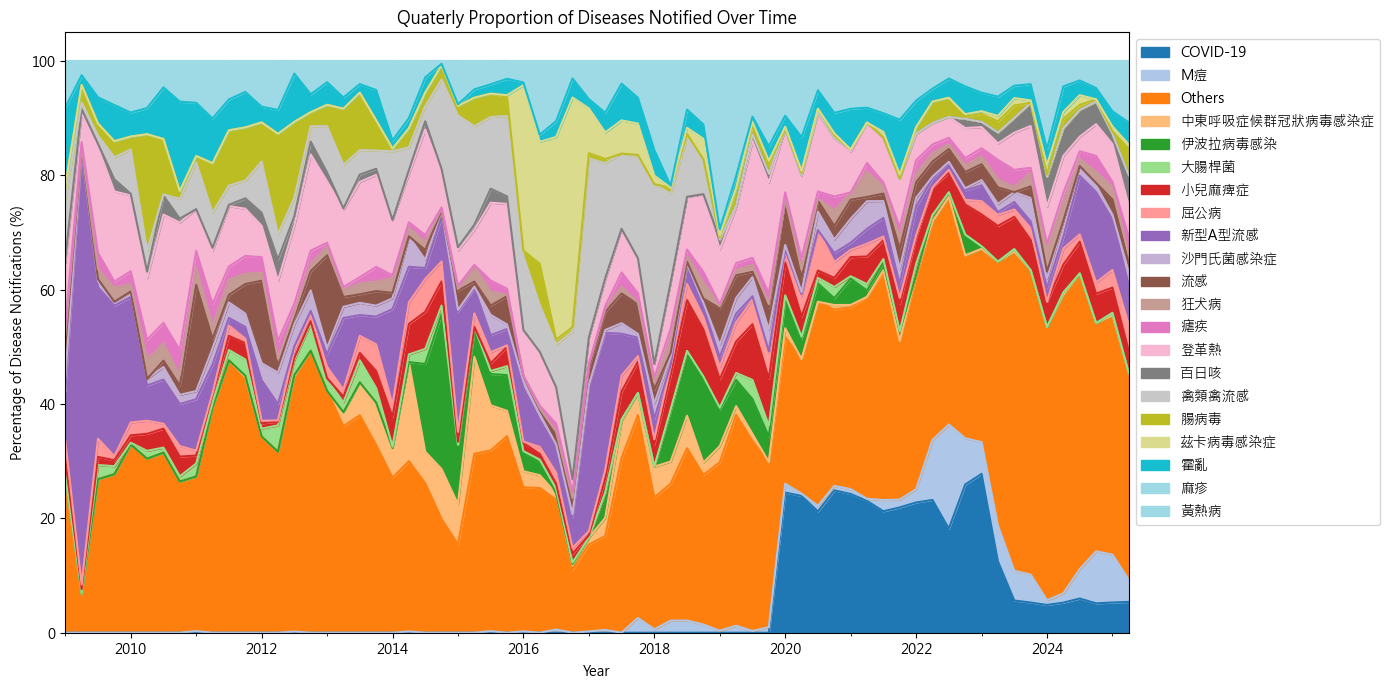

In [65]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Microsoft JhengHei'

plt.rcParams['axes.unicode_minus'] = False

# 🟢 Step 1: Categorize diseases not in list_common_diseases as 'other'
df_plot = df_raw.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)

# 🟢 Step 2: Group by month and grouped disease name
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'disease_grouped'])# Y Q M
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# 🟢 Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# 🟢 Step 4: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Quaterly Proportion of Diseases Notified Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_24020\3839880174.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))


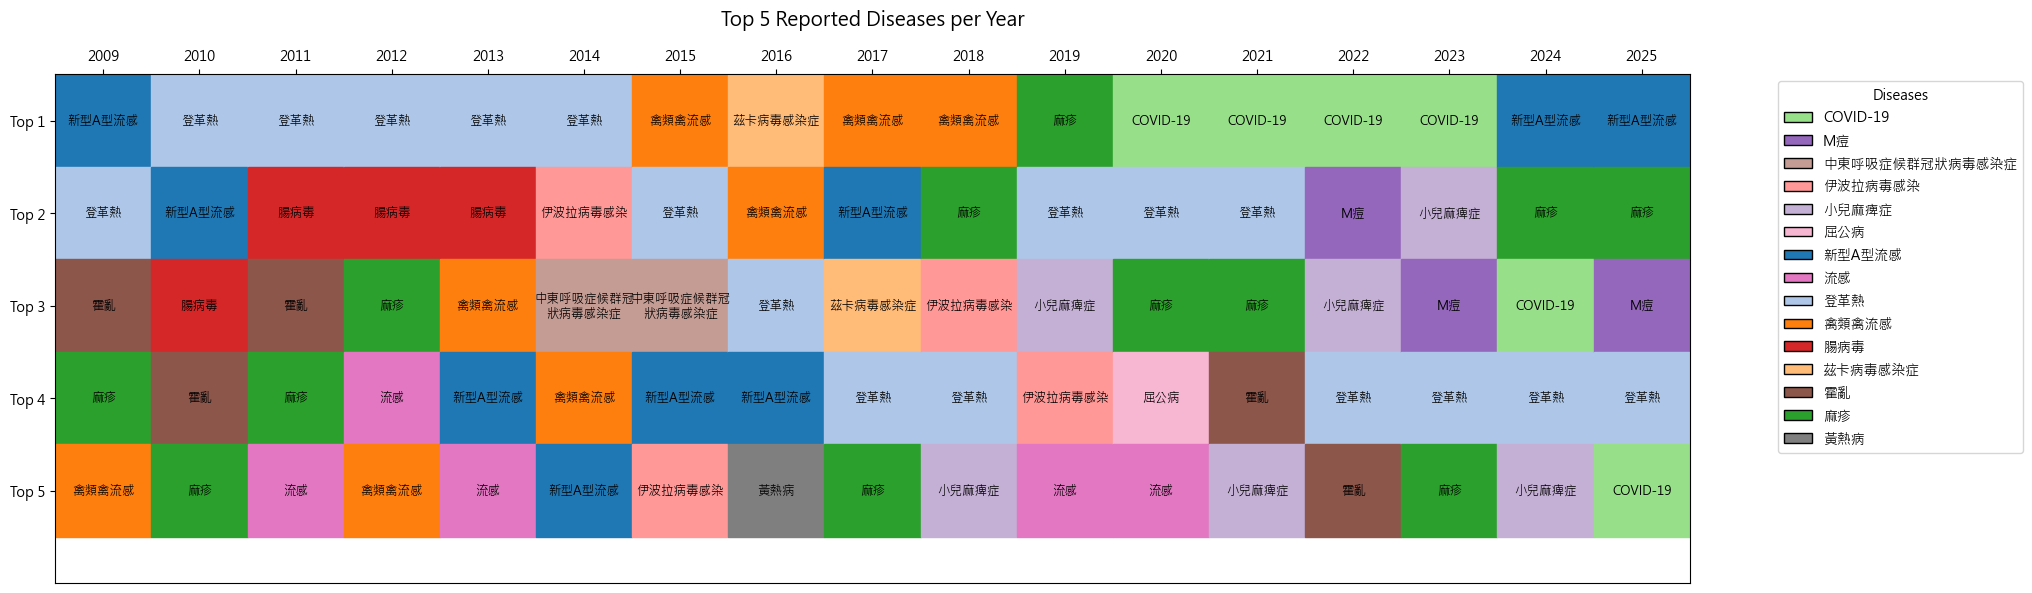

In [82]:
# Top N disease name

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap
# 🟢 Step 1–4: Same as before
df_plot = df_raw[df_raw['disease_name'].isin(list_common_diseases)].copy()
df_plot['year'] = df_plot['date'].dt.year

df_counts = (
    df_plot
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

ranked = (
    top5_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)
years = ranked['year'].tolist()
disease_table = pd.DataFrame([r + [None] * (5 - len(r)) for r in ranked['disease_name']], index=years).T

# 🟢 Assign unique color
all_diseases = pd.unique(disease_table.values.ravel())
color_map = dict(zip(all_diseases, plt.cm.tab20.colors[:len(all_diseases)]))

# 🟢 Step 5: Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.2, 6))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, 5)


# Draw cells
for col, year in enumerate(years):
    for row in range(5):
        disease = disease_table.iloc[row, col]
        color = color_map.get(disease, 'lightgray')
        ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(disease, width=8)) if disease else ''
        ax.text(col + 0.5, 4 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# 🟢 Step 6: Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')  # move x-axis label to top
ax.xaxis.tick_top()

# 🟢 Step 6.5: Left Y-axis for "Top 1" to "Top 5"
ax.set_yticks([i + 0.5 for i in range(5)])
ax.set_yticklabels([f"Top {i+1}" for i in range(5)][::-1], fontsize=10)

# 🟢 Step 7: Legend
legend_elements = [
    Patch(facecolor=color_map[d], edgecolor='black', label=d)
    for d in sorted(color_map) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title("Top 5 Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()



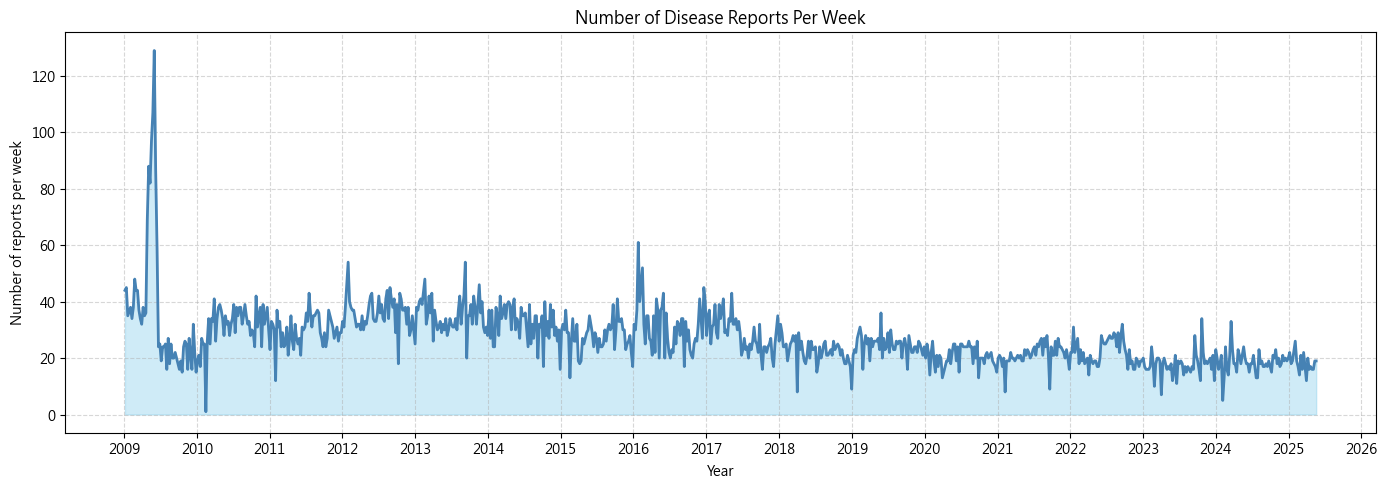

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 🟢 Step 1: Ensure the 'date' column is in datetime format
df_raw['date'] = pd.to_datetime(df_raw['date'])

# 🟢 Step 2: Create a new 'week' column that represents the start of each week
df_raw['week'] = df_raw['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 3: Group by week and count number of reports per week
df_weekly_counts = df_raw.groupby('week').size().reset_index(name='count')

# 🟢 Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Dot plot by disease

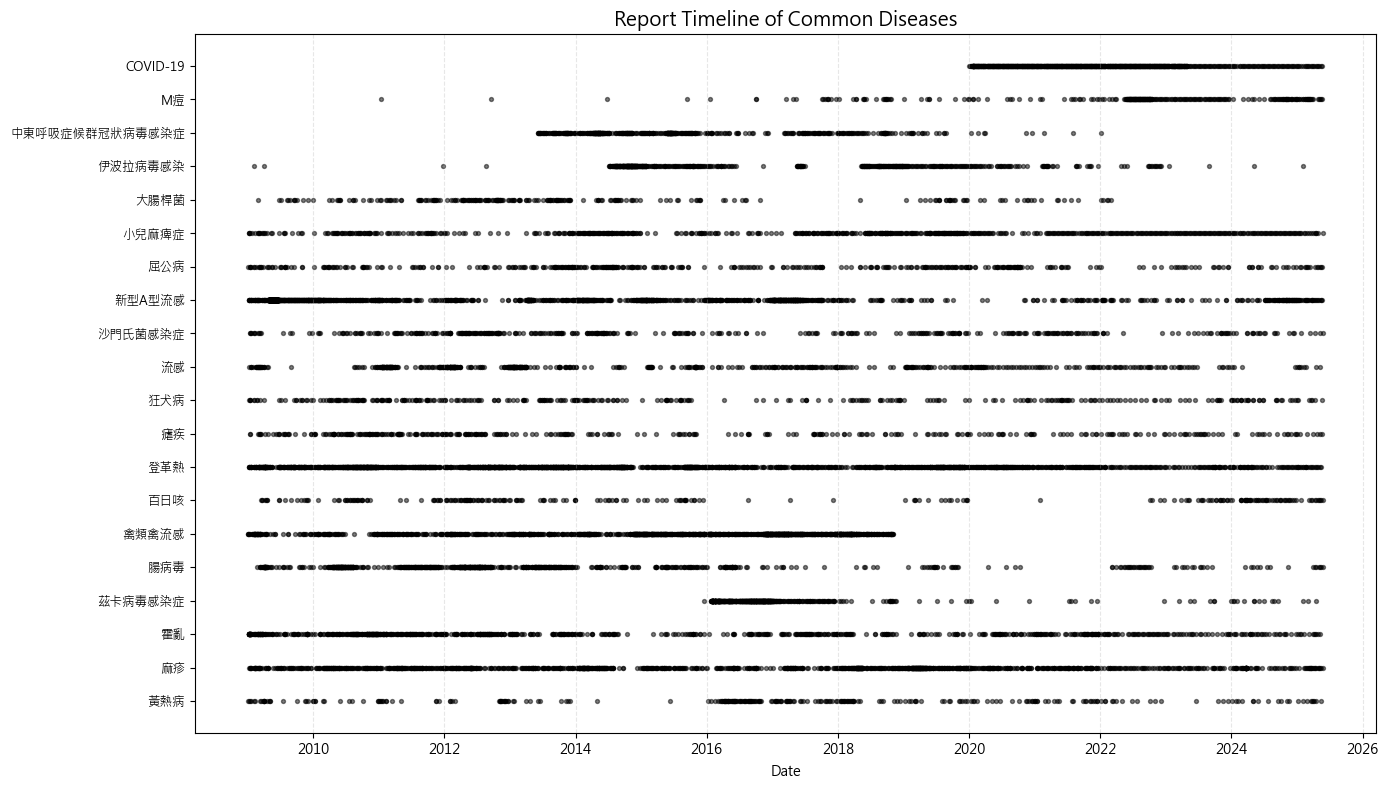

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 🟢 Filter to common diseases only
df_plot = df_raw[df_raw['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])

# 🟢 Sort diseases for consistent Y-axis
diseases_sorted = sorted(df_plot['disease_name'].unique())
disease_to_y = {disease: i for i, disease in enumerate(diseases_sorted)}

# 🟢 Map disease name to Y-position
df_plot['y'] = df_plot['disease_name'].map(disease_to_y)

# 🟢 Create the dot plot
fig, ax = plt.subplots(figsize=(14, len(diseases_sorted) * 0.4))
ax.scatter(df_plot['date'], df_plot['y'], s=8, color='black', alpha=0.5)

# 🟢 Format y-axis
ax.set_yticks(range(len(diseases_sorted)))
ax.set_yticklabels(diseases_sorted, fontsize=9)
ax.invert_yaxis()  # Optional: put top disease at the top

# 🟢 Format x-axis
ax.set_xlabel("Year")
ax.set_title("Report Timeline of Common Diseases", fontsize=14)
ax.grid(True, axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
